In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dropout,  Input, Layer,Conv1DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from pandas_datareader import data

from PyEMD import EMD,EEMD,CEEMDAN,Visualisation

import warnings
warnings.filterwarnings("ignore")

In [2]:
shares_name='LLOY.L'

In [3]:
start = '2017-01-01'
end = '2019-01-01'
GSPC = pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])#Choose the data
print(GSPC)
print(GSPC.isnull().sum().sort_values(ascending = False))

GSPC_test = pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])#Choose the data
GSPC_test

            Adj Close
Date                 
2017-01-03  49.659492
2017-01-04  49.774754
2017-01-05  49.682545
2017-01-06  50.643150
2017-01-09  50.120583
...               ...
2018-12-21  42.512680
2018-12-24  42.042244
2018-12-27  41.291191
2018-12-28  42.265087
2018-12-31  42.793293

[505 rows x 1 columns]
Adj Close    0
dtype: int64


,Adj Close
Date,
2017-01-03,49.659492
2017-01-04,49.774754
2017-01-05,49.682552
2017-01-06,50.643154
2017-01-09,50.120579
...,...
2018-12-21,42.512680
2018-12-24,42.042244
2018-12-27,41.291199


In [4]:
start = '2016-01-01'
end = '2019-01-01'
df=pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])
df = df[['Adj Close']]

In [5]:
def create_noisy(data):
    data_noisy = pd.DataFrame()
    for i in range(0,100):
        data_noisy= pd.concat([data_noisy,pd.Series(data.values[:,0])], axis=1)
    return data_noisy.T

In [6]:
def create_pure(data):
    data_pure = pd.DataFrame()
    for i in range(2,52):
        data_pure['SMA{}'.format(i)] = 0
        data_pure['SMA{}'.format(i)] = data[['Adj Close']].rolling(window=i).mean()
    
    data_pure=data_pure.iloc[:,-len(GSPC_noisy.T):]
    data=data.iloc[-len(GSPC_noisy.T):]
    for i in range(2,52):
        data_pure['EMA{}'.format(i)] = 0
        data_pure['EMA{}'.format(i)] = data[['Adj Close']].ewm(span=i, adjust=False).mean()
    
    return data_pure.T

In [7]:
GSPC_noisy=create_noisy(GSPC)

GSPC_pure=create_pure(df).iloc[:,-len(GSPC_noisy.T):]

In [8]:
mm_t_g = MinMaxScaler()
noise_mm = mm_t_g.fit_transform(GSPC_noisy.T).T
prue_mm=mm_t_g.fit_transform(GSPC_pure.T).T
print(prue_mm.shape)
print(noise_mm.shape)

(100, 505)
(100, 505)


In [9]:
X_train_mm = np.asarray(noise_mm)
X_train_mm=X_train_mm.reshape((len(X_train_mm), len(X_train_mm[0]), 1))
Y_train_mm = np.asarray(prue_mm)
Y_train_mm=Y_train_mm.reshape((len(Y_train_mm), len(Y_train_mm[0]), 1))
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=1)

In [10]:
keras.backend.clear_session()

In [11]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform',input_shape=(None, 1)))
    model.add(Conv1D(32, kernel_size=3,activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform'))
    model.add(Conv1DTranspose(32, kernel_size=3, activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform'))
    model.add(Conv1DTranspose(128, kernel_size=3,activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform'))
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='binary_crossentropy')
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         512       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          12320     
                                                                 
 conv1d_transpose (Conv1DTra  (None, None, 32)         3104      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, None, 128)        12416     
 ranspose)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 1)           385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-traina

In [12]:
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=20, batch_size=10, verbose=0)

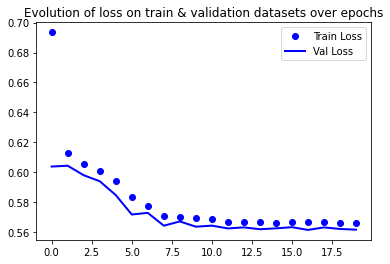

In [13]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']

plt.figure()
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'bo', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'b', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

1/1 [==============================] - 0s 112ms/step


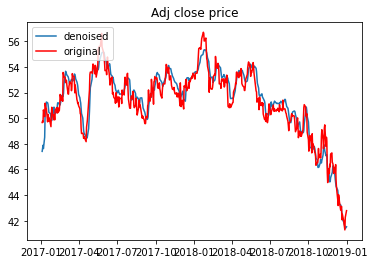

In [14]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(GSPC_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
noise_mm_T=pd.DataFrame(noise_mm_T,columns=['Adj Close'],index=GSPC_test.index)
Y_test_mm_cnn=pd.DataFrame(Y_test_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
plt.figure()
plt.plot(pure_mm_cnn)
plt.plot(GSPC_test,'r')
plt.title('Adj close price')
plt.legend(['denoised', 'original'], loc='upper left')

# regression

In [15]:
original=GSPC_test
recon=pure_mm_cnn

In [16]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['Adj Close'].shift(i)
    return ret_dataset

In [17]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

3.510510170910005
0.8605188201671387
1.8215809473033182
1.6361071708223147
3.0336945729682268
0.7963672988872731
1.5782422981347048
0.2812012129810372
10.049313186361914
8.309547286510833
The last MSE: 8.309547286510833
The average MSE: 3.1877082965046766


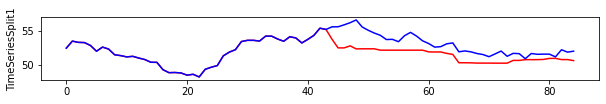

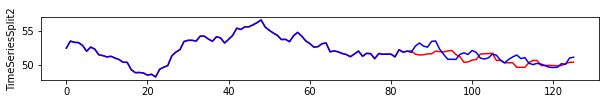

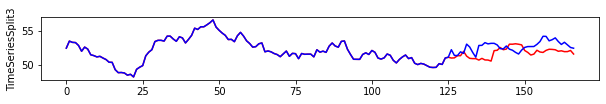

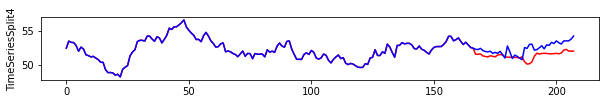

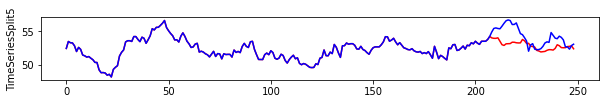

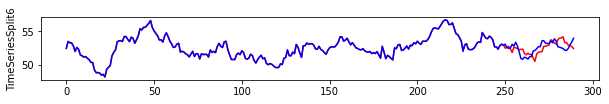

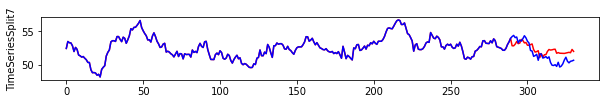

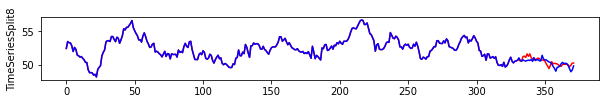

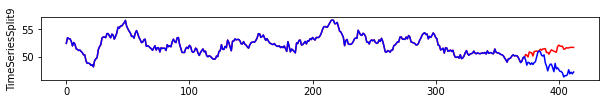

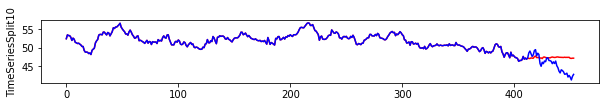

In [18]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0

for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [19]:
from bayes_opt import BayesianOptimization
def rf_do(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           #max_delta_step = float(max_delta_step),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(recon_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(recon_m.iloc[test_index,:],test_predict)
    return msetest

In [20]:
rf_bo = BayesianOptimization(
        rf_do,
                {'max_depth':(1,20),
                'learning_rate': (0.01,0.3),
                'n_estimators': (100,1000),
                'min_child_weight': (0,2),
                #'max_delta_step': (0.01,1),
                'subsample':(0.5,1),
                'colsample_bytree': (0.5,1),
                'reg_alpha': (0.01,1),
                'reg_lambda': (0.2,1),
                'scale_pos_weight': (0.2,1),
                'gamma':(0,1)}
    )
rf_bo.maximize()#init_points=20, n_iter=10
rf_bo_p=rf_bo.max
rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -8.618    |  0.5524   |  0.3869   |  0.1495   |  2.621    |  1.129    |  342.5    |  0.1547   |  0.254    |  0.7561   |  0.9992   |
|  2        | -7.115    |  0.9291   |  0.9839   |  0.1535   |  6.245    |  1.071    |  709.1    |  0.3024   |  0.4159   |  0.5686   |  0.6056   |
|  3        | -7.167    |  0.551    |  0.2818   |  0.1552   |  3.208    |  1.899    |  342.3    |  0.1856   |  0.8884   |  0.3281   |  0.8988   |
|  4        | -7.116    |  0.9325   |  0.0494   |  0.2004   |  17.16    |  1.447    |  275.0    |  0.3954   |  0.7711   |  0.5868   |  0.9289   |
|  5        | -6.896    |  0.5431   |  0.9449   |  0.2824   |  13.36    |  0.7996   |  791.6    |  0.7909   |  0.7034   |  0

{'target': -5.4970879554748535,
 'params': {'colsample_bytree': 0.5815111109300191,
  'gamma': 0.08660162907757019,
  'learning_rate': 0.15706774752703773,
  'max_depth': 14,
  'min_child_weight': 2,
  'n_estimators': 876,
  'reg_alpha': 0.5788634143839041,
  'reg_lambda': 0.43178344601382207,
  'scale_pos_weight': 0.9058099163144833,
  'subsample': 0.5332989964640906}}

1.3885068524073065
0.5237442878253826
1.093734338823862
0.6323041132578155
2.356676139047145
0.3386738779975908
0.3597294290904268
0.3972477360998377
3.6582949212397358
6.914665350600688
The last MSE: 6.914665350600688
The average MSE: 1.7663577046389793


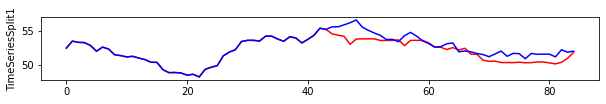

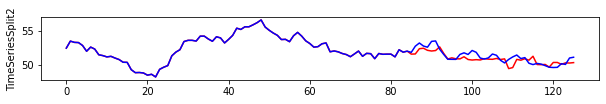

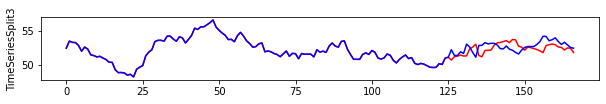

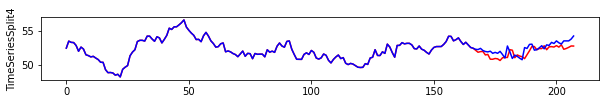

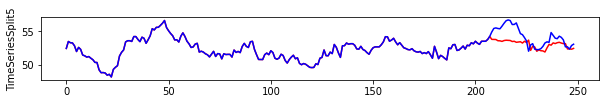

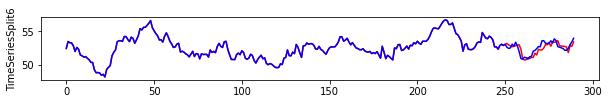

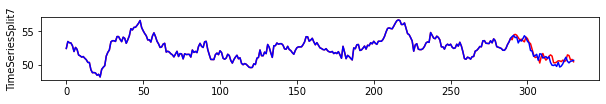

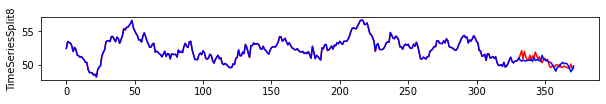

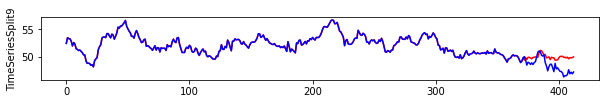

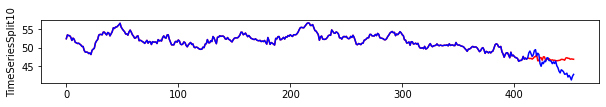

In [21]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [22]:
def rf_oo(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(original_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(original_m.iloc[test_index,:],test_predict)
    return msetest

In [23]:
rf_bo = BayesianOptimization(
        rf_oo,
                {'max_depth':(1,20),
                'learning_rate': (0.01,0.3),
                'n_estimators': (100,1000),
                'min_child_weight': (0,2),
                'subsample':(0.5,1),
                'colsample_bytree': (0.5,1),
                'reg_alpha': (0.01,1),
                'reg_lambda': (0.2,1),
                'scale_pos_weight': (0.2,1),
                'gamma':(0,1)}
    )
rf_bo.maximize()#init_points=20, n_iter=10
rf_bo_p=rf_bo.max
rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -4.418    |  0.5065   |  0.3429   |  0.2904   |  19.78    |  0.3633   |  684.3    |  0.4835   |  0.3673   |  0.4897   |  0.5055   |
|  2        | -5.365    |  0.5766   |  0.4757   |  0.146    |  10.96    |  0.7265   |  522.7    |  0.407    |  0.3385   |  0.6876   |  0.6198   |
|  3        | -8.48     |  0.8677   |  0.3452   |  0.249    |  2.764    |  0.0154   |  387.6    |  0.138    |  0.2198   |  0.961    |  0.9454   |
|  4        | -6.377    |  0.8878   |  0.2413   |  0.226    |  3.797    |  0.6885   |  125.0    |  0.8434   |  0.4563   |  0.9785   |  0.8113   |
|  5        | -5.904    |  0.7371   |  0.2564   |  0.04768  |  6.543    |  0.1411   |  342.6    |  0.921    |  0.5871   |  0

{'target': -4.418391002969967,
 'params': {'colsample_bytree': 0.5064803679228773,
  'gamma': 0.3428719619042484,
  'learning_rate': 0.2903940358009413,
  'max_depth': 20,
  'min_child_weight': 0,
  'n_estimators': 684,
  'reg_alpha': 0.4834510873712731,
  'reg_lambda': 0.36725349707128524,
  'scale_pos_weight': 0.48971095295248807,
  'subsample': 0.5054718309095568}}

# EMDCNN

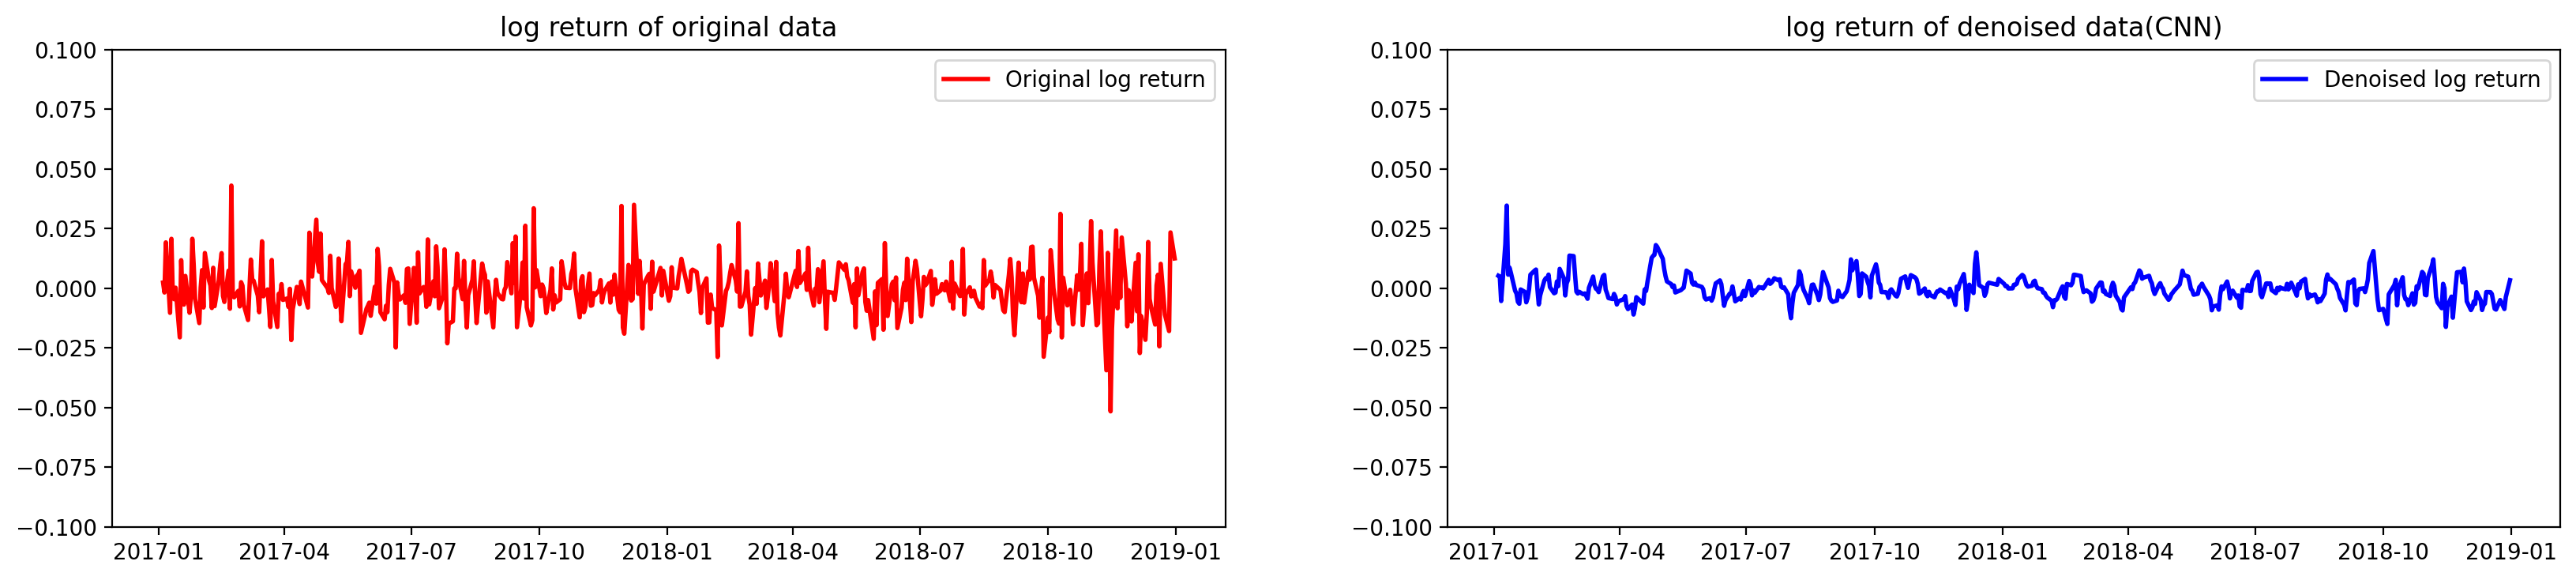

In [24]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.1,0.1)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.1,0.1)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [25]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=0.8):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [26]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1,percentage=1)

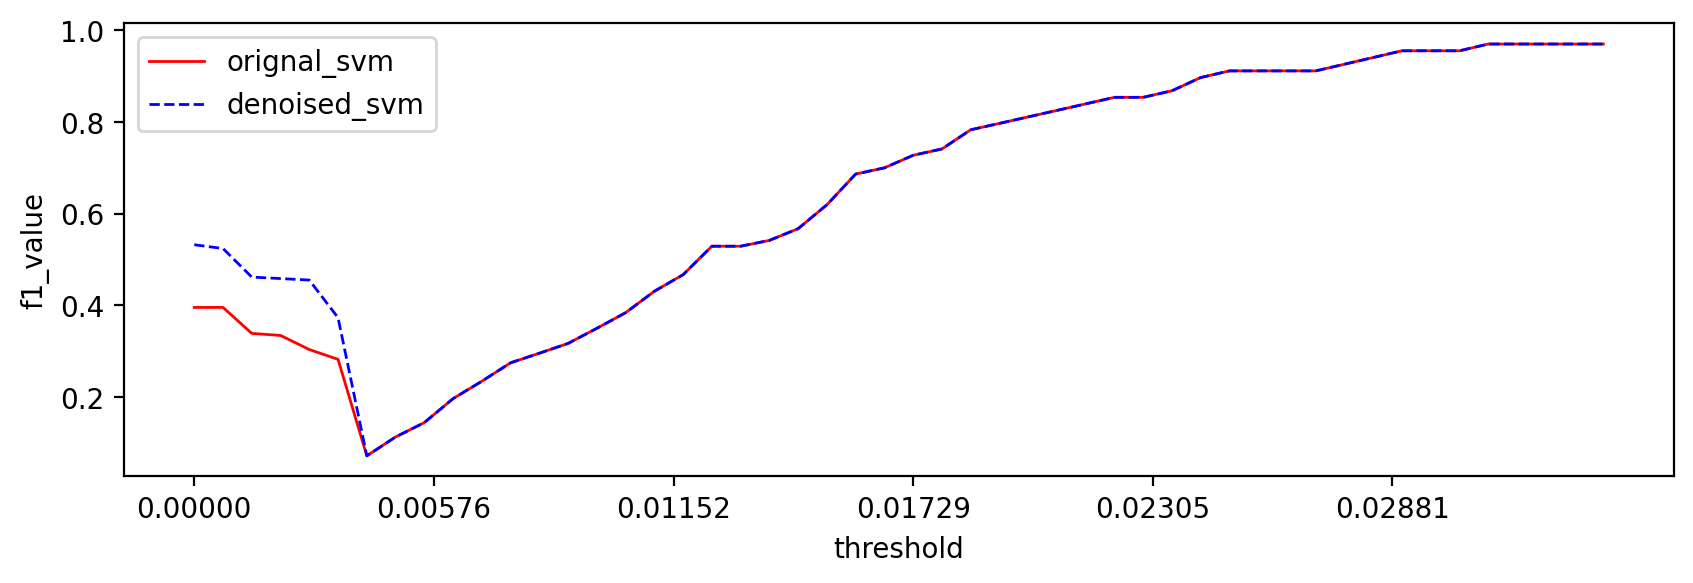

In [27]:
plt.figure(figsize=(10,3),dpi=200)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

# Strategies 

## Bollinger band

In [28]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()#.shift(1)
    rolling_std = close_prices.rolling(window,min_periods=1).std()#.shift(1)
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [29]:
def buy_signal_function(dataset):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Adj Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Adj Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,3]):
            buy_signal.iloc[i,4]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,3]):
                buy_signal.iloc[i,5]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,2]):
            buy_signal.iloc[i,4]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,2]):
                buy_signal.iloc[i,5]=-1
    return buy_signal

In [30]:
GSPC_test_signal=buy_signal_function(GSPC_test_n)


pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn)


In [31]:

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnn_signal:\n',pure_mm_cnn_signal.signal.value_counts(),'\n')


GSPC_test_signal:
 -1.0    14
 1.0    12
Name: signal, dtype: int64 

pure_mm_cnn_signal:
  1.0    9
-1.0    6
Name: signal, dtype: int64 



In [32]:
print(GSPC_test[GSPC_test_signal.signal == 1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == 1.0])

            Adj Close
Date                 
2017-03-27  51.450054
2017-04-06  49.243916
2018-02-06  52.019310
2018-03-23  50.910851
2018-05-31  51.245914
2018-06-05  50.662193
2018-08-13  49.762291
2018-08-31  48.941994
2018-09-07  48.479813
2018-10-02  47.431648
2018-11-16  44.980415
2018-12-10  43.651638
            Adj Close
Date                 
2017-03-30  51.219517
2017-09-01  50.069672
2018-02-07  52.954823
2018-03-27  51.123108
2018-06-04  51.553993
2018-08-10  50.151436
2018-10-04  48.636623
2018-11-20  45.690201
2018-12-12  44.031284


In [33]:
print(GSPC_test[GSPC_test_signal.signal == -1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == -1.0])

            Adj Close
Date                 
2017-02-15  51.849670
2017-02-22  53.563385
2017-04-27  53.410172
2017-05-25  56.608433
2017-07-19  52.720963
2017-07-25  53.433399
2017-09-14  52.200127
2017-09-21  53.025581
2017-10-26  54.189079
2018-01-10  54.228386
2018-08-01  51.408058
2018-09-20  50.832001
2018-11-02  49.098808
2018-11-08  49.230865
            Adj Close
Date                 
2017-02-24  53.240627
2017-05-03  53.479870
2017-07-21  52.744186
2017-10-31  53.685944
2018-01-15  55.501942
2018-08-06  50.727051


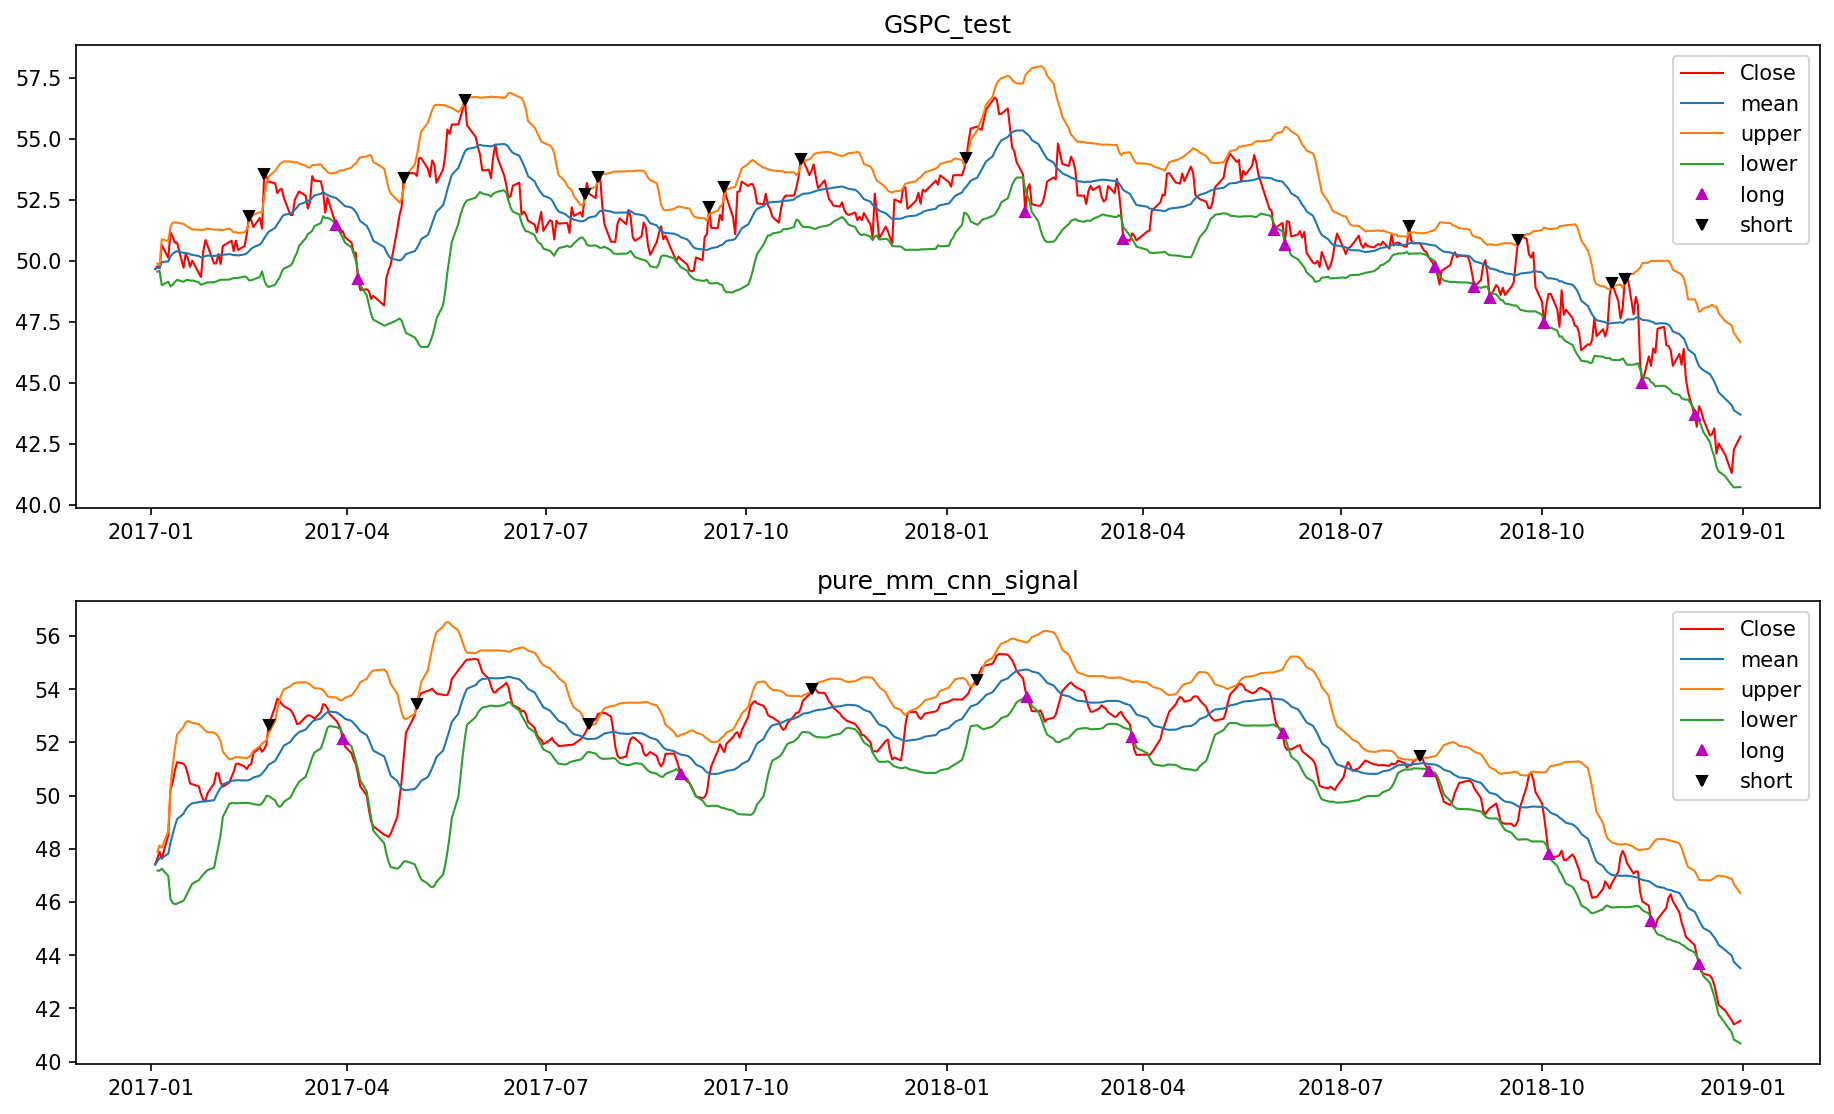

In [34]:
plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_signal['Price'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn_signal')
plt.plot(pure_mm_cnn_signal['Price'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == 1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == -1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()    


## MACD

In [35]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Adj Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Adj Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

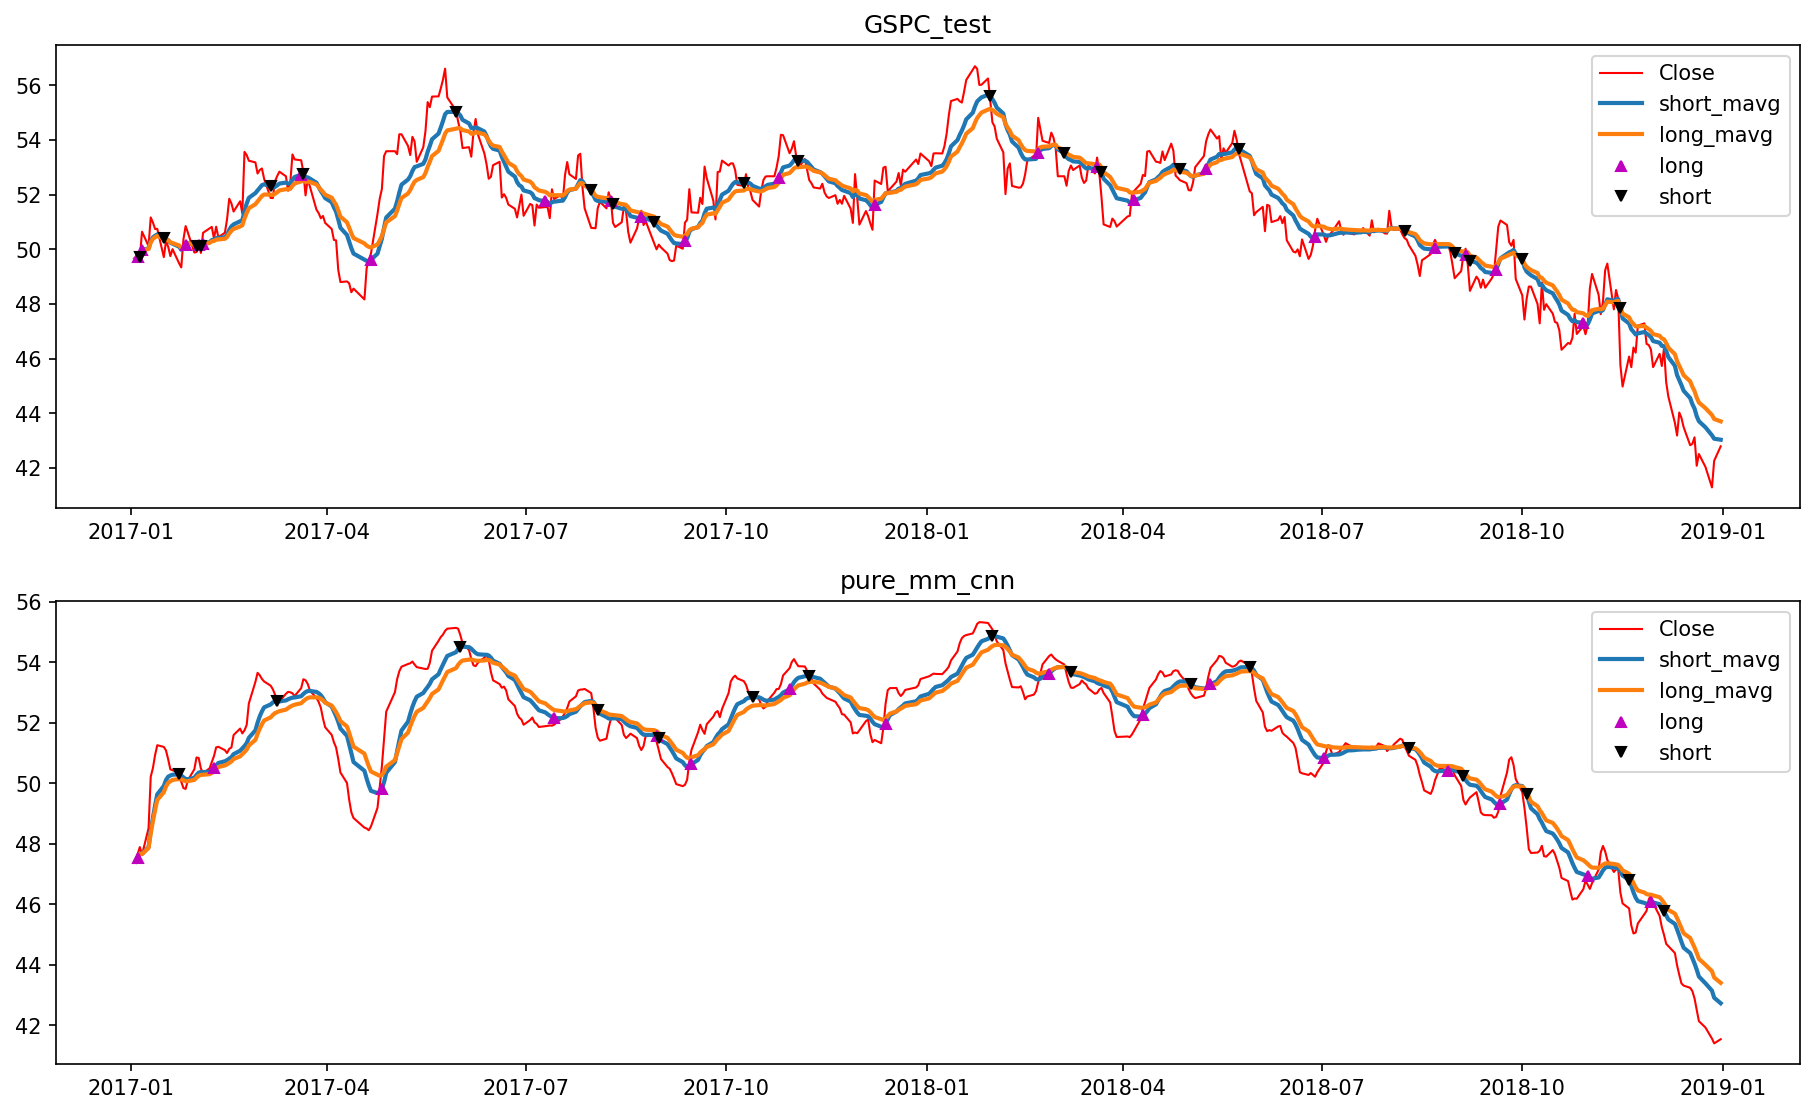

In [36]:
GSPC_test_macd=MACD(GSPC_test_n,short_window = 14,long_window = 22)
pure_mm_cnn_macd=MACD(pure_mm_cnn,short_window = 14,long_window = 22)
#pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_n['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == 1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == -1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [37]:
print('GSPC_test_macd:\n',GSPC_test_macd.positions.value_counts(),'\n')
print('pure_mm_cnn_macd:\n',pure_mm_cnn_macd.positions.value_counts(),'\n')

GSPC_test_macd:
  0.0    460
 1.0     22
-1.0     22
Name: positions, dtype: int64 

pure_mm_cnn_macd:
  0.0    472
 1.0     16
-1.0     16
Name: positions, dtype: int64 



In [38]:
print(GSPC_test[GSPC_test_macd['positions']==1])
print(GSPC_test[pure_mm_cnn_macd['positions']==1])

            Adj Close
Date                 
2017-01-04  49.774754
2017-01-06  50.643154
2017-01-26  50.850643
2017-02-01  50.274273
2017-02-03  50.604725
2017-03-20  53.256001
2017-04-21  49.847950
2017-07-10  51.543877
2017-08-09  51.814922
2017-08-23  51.413982
2017-09-12  50.973736
2017-10-25  53.410789
2017-12-08  52.514587
2018-02-21  54.810127
2018-03-20  53.355762
2018-04-06  52.137230
2018-05-09  53.945621
2018-06-28  50.710838
2018-08-22  50.345055
2018-09-05  50.023174
2018-09-19  49.957146
2018-10-29  47.192295
            Adj Close
Date                 
2017-01-04  49.774754
2017-02-08  50.397236
2017-04-26  52.202114
2017-07-14  51.838150
2017-08-30  49.998917
2017-09-15  51.351086
2017-10-30  53.512989
2017-12-13  53.020081
2018-02-26  53.890347
2018-04-10  52.718983
2018-05-11  54.383423
2018-07-02  50.516262
2018-08-28  50.171738
2018-09-21  51.054836
2018-10-31  47.225315
2018-11-29  46.333958


In [39]:
print(GSPC_test[GSPC_test_macd['positions']==-1])
print(GSPC_test[pure_mm_cnn_macd['positions']==-1])

            Adj Close
Date                 
2017-01-05  49.682552
2017-01-16  49.713287
2017-01-31  49.897724
2017-02-02  49.866978
2017-03-06  51.880413
2017-03-21  52.825653
2017-05-30  55.075134
2017-07-31  50.784966
2017-08-10  50.965878
2017-08-29  50.195450
2017-10-09  52.318054
2017-11-03  52.978413
2018-01-30  55.439045
2018-03-05  52.671810
2018-03-22  51.932835
2018-04-27  52.526855
2018-05-24  53.507832
2018-08-08  50.410862
2018-08-31  48.941994
2018-09-07  48.479813
2018-10-01  48.314743
2018-11-15  45.764484
            Adj Close
Date                 
2017-01-23  49.490425
2017-03-09  52.679638
2017-06-01  54.331707
2017-08-03  51.505157
2017-08-31  50.171867
2017-10-13  51.807053
2017-11-08  52.530304
2018-01-31  54.645042
2018-03-08  53.064884
2018-05-02  52.153931
2018-05-29  52.121490
2018-08-10  50.151436
2018-09-04  49.808586
2018-10-03  48.190945
2018-11-19  46.078110
2018-12-05  46.383476


## MA

In [40]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Adj Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Adj Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

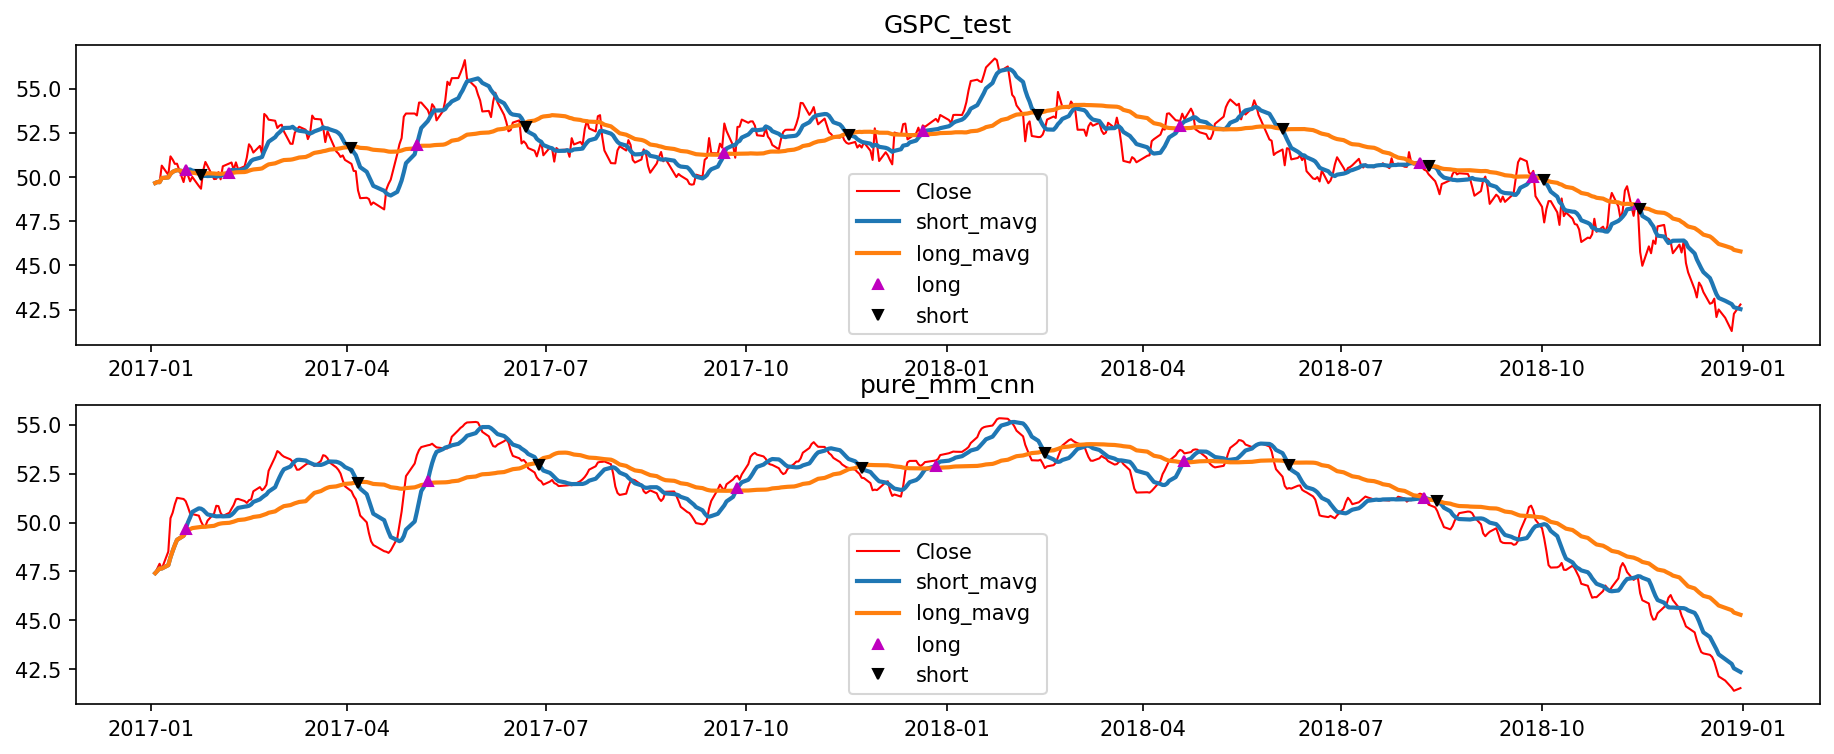

In [41]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnn_ma=MA(pure_mm_cnn,short_window = 10,long_window = 50)
#pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == 1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == -1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [42]:
print('GSPC_test_ma:\n',GSPC_test_ma.positions.value_counts(),'\n')
print('pure_mm_cnn_ma:\n',pure_mm_cnn_ma.positions.value_counts(),'\n')

GSPC_test_ma:
  0.0    486
 1.0      9
-1.0      9
Name: positions, dtype: int64 

pure_mm_cnn_ma:
  0.0    492
 1.0      6
-1.0      6
Name: positions, dtype: int64 



In [43]:
print(GSPC_test[GSPC_test_ma['positions']==1])
print(GSPC_test[pure_mm_cnn_ma['positions']==1])

            Adj Close
Date                 
2017-01-17  50.297333
2017-02-06  50.766106
2017-05-03  53.479870
2017-09-21  53.025581
2017-12-21  52.915520
2018-04-18  53.159229
2018-08-06  50.727051
2018-09-27  50.345055
2018-11-14  48.190945
            Adj Close
Date                 
2017-01-17  50.297333
2017-05-08  53.781879
2017-09-27  52.829041
2017-12-27  53.285007
2018-04-20  53.264618
2018-08-08  50.410862


In [44]:
print(GSPC_test[GSPC_test_ma['positions']==-1])
print(GSPC_test[pure_mm_cnn_ma['positions']==-1])

            Adj Close
Date                 
2017-01-24  49.336723
2017-04-03  50.743057
2017-06-22  51.884609
2017-11-17  51.877811
2018-02-12  52.255154
2018-06-04  51.553993
2018-08-10  50.151436
2018-10-02  47.431648
2018-11-15  45.764484
            Adj Close
Date                 
2017-04-06  49.243916
2017-06-28  51.574856
2017-11-23  51.665550
2018-02-15  52.734711
2018-06-07  51.594521
2018-08-14  49.438000


## Strategies backtest

In [45]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Adj Close']=dataset['Adj Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [46]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnn_backtesting=combinesig(GSPC_test,pure_mm_cnn_ma,pure_mm_cnn_macd,pure_mm_cnn_signal)


In [47]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=share_number+cash//(100*dataset['Adj Close'][i])*100
            if cash//(100*dataset['Adj Close'][i])*100>0:
                cash=cash-cash//(100*dataset['Adj Close'][i])*100*dataset['Adj Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Adj Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Adj Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [48]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnn)


-0.2116423389854431
-0.1367583673095703


In [49]:
macdreturn=backtest(GSPC_backtesting,signal='macdsig')
macdreturn_cnn=backtest(pure_mm_cnn_backtesting,signal='macdsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(macdreturn)
print(macdreturn_cnn)
#print(mareturn_lstm)

-0.10540871630477905
-0.06611724761962891


In [50]:
bbreturn=backtest(GSPC_backtesting,signal='bbsig')
bbreturn_cnn=backtest(pure_mm_cnn_backtesting,signal='bbsig')
print(bbreturn)
print(bbreturn_cnn)


0.03204086848449707
-0.08490485673141479
